# データセットの分析・可視化

データセットの読み込み

In [1]:
import os
import pandas as pd

# Livedoorニュースコーパスのディレクトリパス
data_dir = "ldcc-20140209.tar//text"

def load_livedoor_corpus(data_dir):
    categories = os.listdir(data_dir)
    data = []

    for category in categories:
        category_path = os.path.join(data_dir, category)
        if os.path.isdir(category_path):
            files = os.listdir(category_path)
            for file in files:
                if file.endswith(".txt"):  # 対象はテキストファイル
                    with open(os.path.join(category_path, file), 'r', encoding='utf-8') as f:
                        lines = f.readlines()
                        # 記事本文のデータのみ抽出（仕様に合わせて変更する）
                        title = lines[2].strip()
                        body = "".join(lines[3:]).strip()
                        data.append({"category": category, "title": title, "body": body})

    return pd.DataFrame(data)

# データを読み込む
df = load_livedoor_corpus(data_dir)

dokujo-tsushin：女性向けのエンタメ・恋愛・ライフスタイル系の記事などが中心。

it-life-hack：IT関連の話題や実用的なライフハック情報など。

kaden-channel：家電やガジェット、電子機器の紹介・レビュー系の記事。

livedoor-homme：メンズ向けのファッション・ライフスタイル情報などを扱うサイト。

movie-enter：映画やエンタメ関連のニュースを中心に扱うサイト。

peachy：女性向けの美容・ファッション・恋愛など、幅広いテーマを扱うサイト。

smax：スマートフォン・モバイル関連のニュース・レビューなど。

sports-watch：スポーツ全般の試合結果や選手情報、ニュース記事。

topic-news：そのほかの一般ニュース（時事・話題系）を扱うサイト。

データの基本統計量の確認

In [2]:
# カテゴリごとの記事数
print(df['category'].value_counts())

# 記事本文の単語数を計算
df['word_count'] = df['body'].apply(lambda x: len(x.split()))

# 平均単語数をカテゴリごとに計算
print(df.groupby('category')['word_count'].mean())

category
sports-watch      901
dokujo-tsushin    871
it-life-hack      871
smax              871
movie-enter       871
kaden-channel     865
peachy            843
topic-news        771
livedoor-homme    512
Name: count, dtype: int64
category
dokujo-tsushin    19.980482
it-life-hack      40.119403
kaden-channel     24.787283
livedoor-homme    33.406250
movie-enter       25.862227
peachy            30.696323
smax              72.659013
sports-watch       7.340733
topic-news        14.293126
Name: word_count, dtype: float64


カテゴリごとの記事数

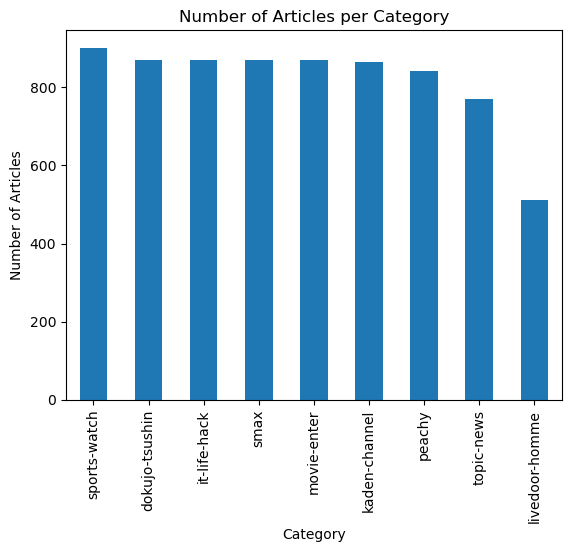

In [3]:
import matplotlib.pyplot as plt

df['category'].value_counts().plot(kind='bar')
plt.title('Number of Articles per Category')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.show()

# データの入手と前処理

In [3]:
import os
import glob
import random

data_dir = "ldcc-20140209.tar//text"  # 解凍したディレクトリ名
categories = [ "dokujo-tsushin", "it-life-hack", "kaden-channel", 
               "livedoor-homme", "movie-enter", "peachy", 
               "smax", "sports-watch", "topic-news" ]

texts = []
labels = []

for i, cat in enumerate(categories):
    cat_dir = os.path.join(data_dir, cat)
    for txt_file in glob.glob(cat_dir + "/*.txt"):
        with open(txt_file, "r", encoding="utf-8") as f:
            lines = f.read().strip().split('\n')
            # 上部2行程度にURL等が含まれることが多いので削除
            # コーパス仕様に合わせて調整してください
            text = "\n".join(lines[2:])
            texts.append(text)
            labels.append(cat)

# シャッフル
combined = list(zip(texts, labels))
random.shuffle(combined)
texts, labels = zip(*combined)

# ラベルをidに変換
label2id = {cat: idx for idx, cat in enumerate(categories)}
id2label = {idx: cat for cat, idx in label2id.items()}
label_ids = [label2id[l] for l in labels]

# split
train_size = int(0.8 * len(texts))
val_size = int(0.1 * len(texts))
test_size = len(texts) - train_size - val_size

train_texts = texts[:train_size]
train_labels = label_ids[:train_size]

val_texts = texts[train_size:train_size+val_size]
val_labels = label_ids[train_size:train_size+val_size]

test_texts = texts[train_size+val_size:]
test_labels = label_ids[train_size+val_size:]

# トークナイザとモデルのロード

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = 'globis-university/deberta-v3-japanese-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(categories),
    ignore_mismatched_sizes=True  # 分類の数
)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at globis-university/deberta-v3-japanese-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at globis-university/deberta-v3-japanese-base and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([9, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# データセットの作成

In [5]:
from datasets import Dataset

train_dataset = Dataset.from_dict({"text": train_texts, "labels": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "labels": val_labels})
test_dataset = Dataset.from_dict({"text": test_texts, "labels": test_labels})

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Trainerで使うために不要な列を削除
train_dataset = train_dataset.remove_columns(["text"])
val_dataset = val_dataset.remove_columns(["text"])
test_dataset = test_dataset.remove_columns(["text"])

# PyTorch tensor形式へ
train_dataset.set_format("torch")
val_dataset.set_format("torch")
test_dataset.set_format("torch")

Map:   0%|          | 0/5900 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

Map:   0%|          | 0/739 [00:00<?, ? examples/s]

# ファインチューニング前

In [6]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

def compute_metrics(eval_pred):
    from sklearn.metrics import accuracy_score, f1_score
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "f1": f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

C:\Users\H3SLAB-008\AppData\Local\Temp\ipykernel_35216\277567243.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [9]:
trainer.evaluate(test_dataset)

{'eval_loss': 2.197908878326416,
 'eval_model_preparation_time': 0.0015,
 'eval_accuracy': 0.10419485791610285,
 'eval_f1': 0.04001071725209657,
 'eval_runtime': 11.9108,
 'eval_samples_per_second': 62.044,
 'eval_steps_per_second': 7.808}

# Trainerを用いたファインチューニング

In [10]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,F1
1,1.319000,0.356683,0.001500,0.934871,0.929010
2,0.393200,0.170745,0.001500,0.964722,0.962207
3,0.101800,0.178274,0.001500,0.968792,0.967162


TrainOutput(global_step=2214, training_loss=0.4635684341596071, metrics={'train_runtime': 839.8478, 'train_samples_per_second': 21.075, 'train_steps_per_second': 2.636, 'total_flos': 4657441896345600.0, 'train_loss': 0.4635684341596071, 'epoch': 3.0})

In [11]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.16589771211147308,
 'eval_model_preparation_time': 0.0015,
 'eval_accuracy': 0.959404600811908,
 'eval_f1': 0.9556850573361884,
 'eval_runtime': 11.6455,
 'eval_samples_per_second': 63.458,
 'eval_steps_per_second': 7.986,
 'epoch': 3.0}

 # 新しいテキストの分類

保存したモデルのロード

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 保存先ディレクトリ
model_dir = ".//results//checkpoint-2214"

# トークナイザーとモデルをロード
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSequenceClassification.from_pretrained(model_dir)

c:\Users\H3SLAB-008\anaconda3\envs\software\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


新しいテキストの分類

In [34]:
# 推論用の新しいテキスト
new_text = ""

# トークナイズ
inputs = tokenizer(new_text, return_tensors="pt", truncation=True, padding=True, max_length=512)

# モデルで推論
outputs = model(**inputs)

# ロジット（スコア）から予測ラベルを取得
predicted_class_id = outputs.logits.argmax(dim=-1).item()

# 分類カテゴリ
categories = [ "dokujo-tsushin", "it-life-hack", "kaden-channel", 
               "livedoor-homme", "movie-enter", "peachy", 
               "smax", "sports-watch", "topic-news" ]
label2id = {cat: idx for idx, cat in enumerate(categories)}
id2label = {idx: cat for cat, idx in label2id.items()}

# ラベルIDを対応するカテゴリ名に変換
predicted_label = id2label[predicted_class_id]  # id2labelは以前作成した辞書

print(f"Predicted Label: {predicted_label}")

Predicted Label: movie-enter


分類結果にどの程度自信を持っているか

In [ ]:
import torch

# ロジットをソフトマックスで確率に変換
probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

# 各クラスの確率を表示
for label, prob in zip(categories, probabilities[0]):
    print(f"{label}: {prob:.4f}")

dokujo-tsushin: 0.0369
it-life-hack: 0.0151
kaden-channel: 0.0075
livedoor-homme: 0.0083
movie-enter: 0.6174
peachy: 0.0107
smax: 0.0011
sports-watch: 0.2802
topic-news: 0.0228


dokujo-tsushin：
女性向けのエンタメ・恋愛・ライフスタイル系の記事などが中心。

it-life-hack：IT関連の話題や実用的なライフハック情報など。

kaden-channel：家電やガジェット、電子機器の紹介・レビュー系の記事。

livedoor-homme：メンズ向けのファッション・ライフスタイル情報などを扱うサイト。

movie-enter：映画やエンタメ関連のニュースを中心に扱うサイト。

peachy：女性向けの美容・ファッション・恋愛など、幅広いテーマを扱うサイト。

smax：スマートフォン・モバイル関連のニュース・レビューなど。

sports-watch：スポーツ全般の試合結果や選手情報、ニュース記事。

topic-news：そのほかの一般ニュース（時事・話題系）を扱うサイト。

# Huggingfaceにアップロード

In [12]:
from huggingface_hub import login

# アクセストークンを指定
login(token="")


In [14]:
from huggingface_hub import HfApi, HfFolder, Repository

save_directory = ".//results//checkpoint-2214"

# アップロード先リポジトリ名
repo_name = "shuntakawamura/9-news-genre-classifications"

# リポジトリを作成
api = HfApi()
api.create_repo(repo_name, exist_ok=True)

# モデルをアップロード
from huggingface_hub import upload_folder

upload_folder(
    repo_id=repo_name,
    folder_path=save_directory,  # ローカル保存したモデルのフォルダ
    commit_message="Upload model",
)
print(f"Model uploaded to: https://huggingface.co/{repo_name}")


model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/885M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]